In [1]:
# visium <- readRDS('/tmp/work/Visium/BRCA_2024/objects/visium_labeled.rds')

/opt/conda/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


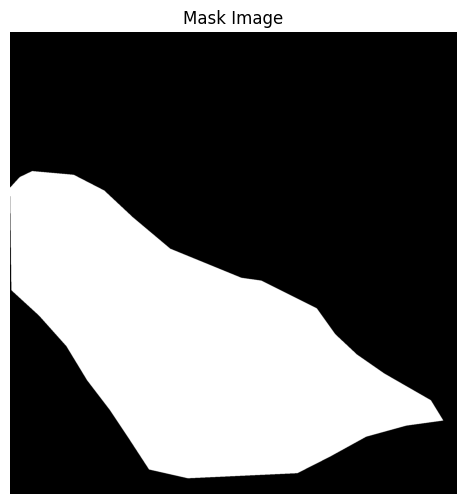

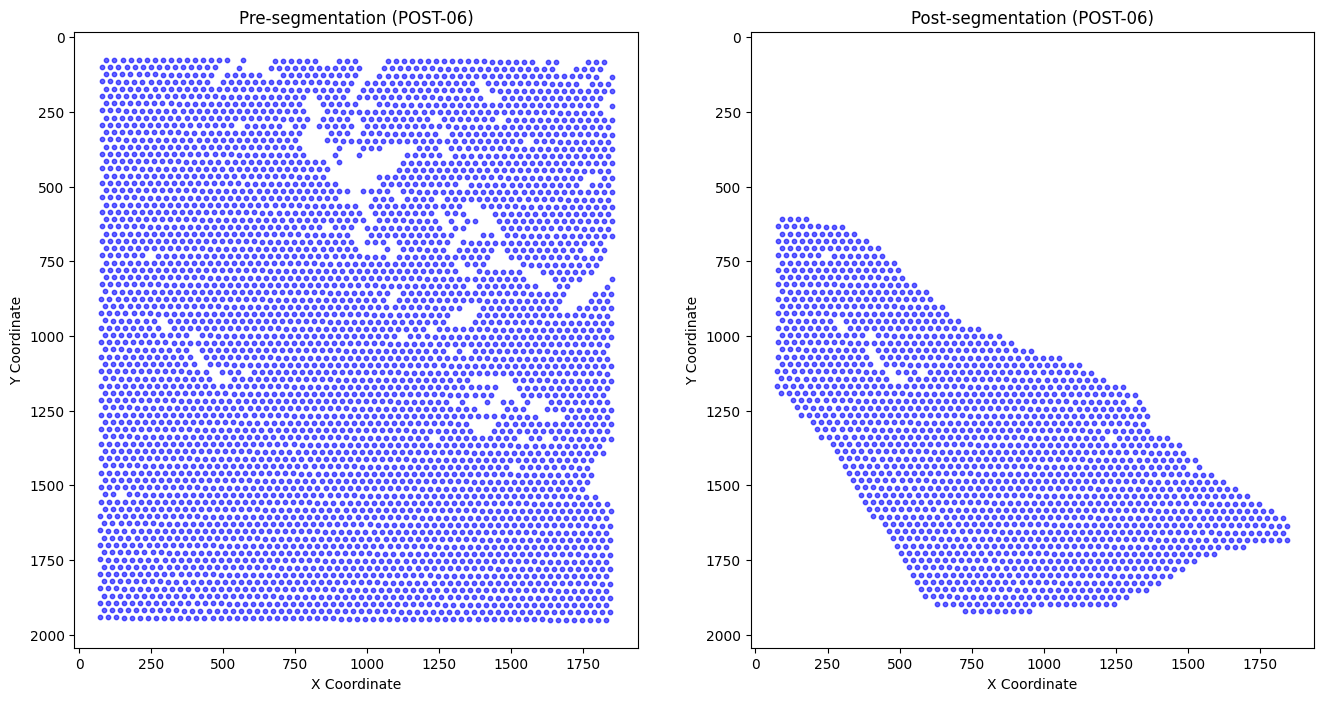

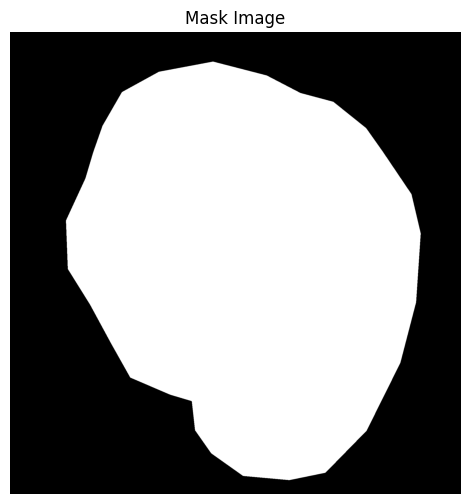

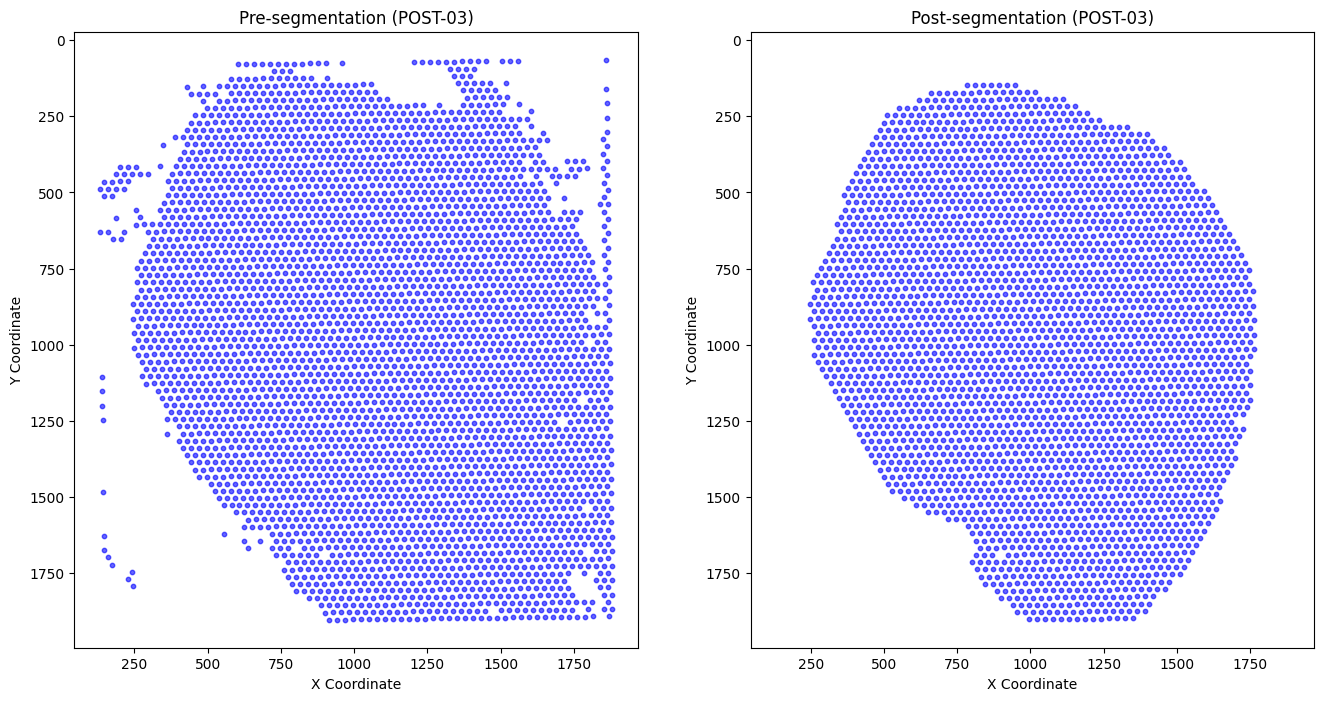

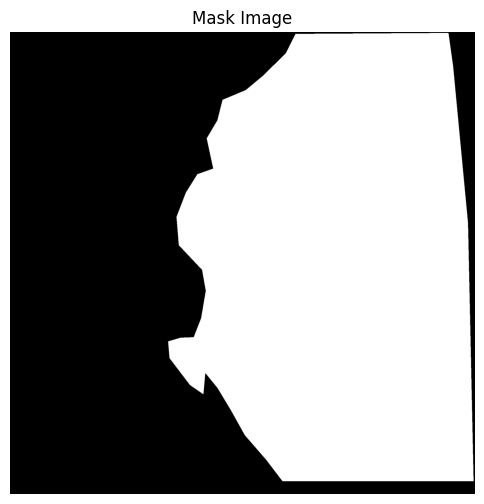

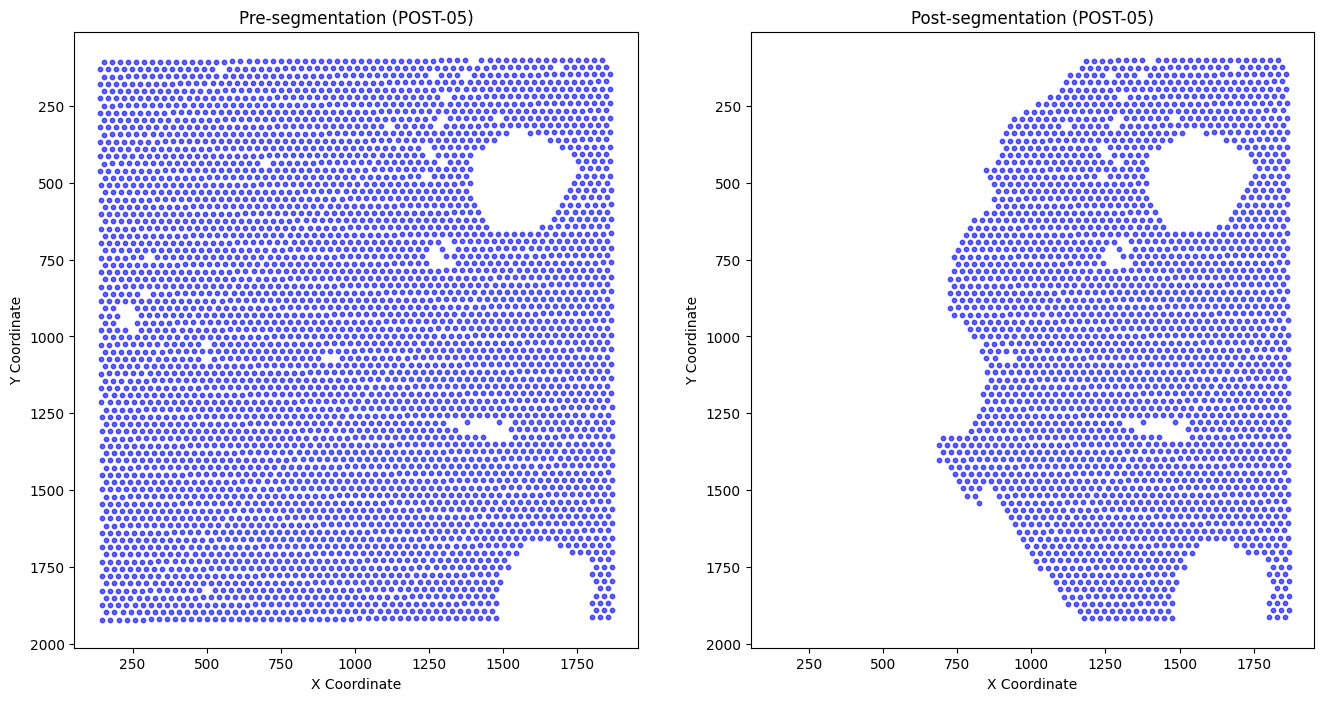

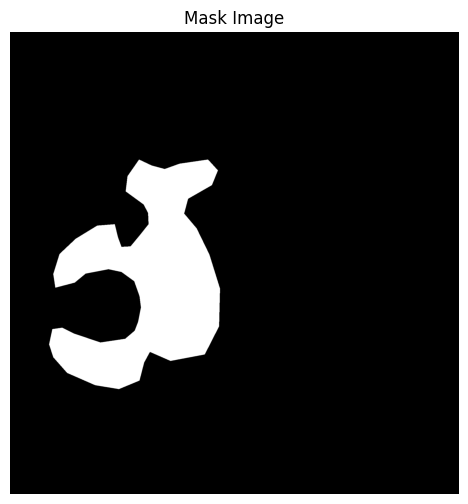

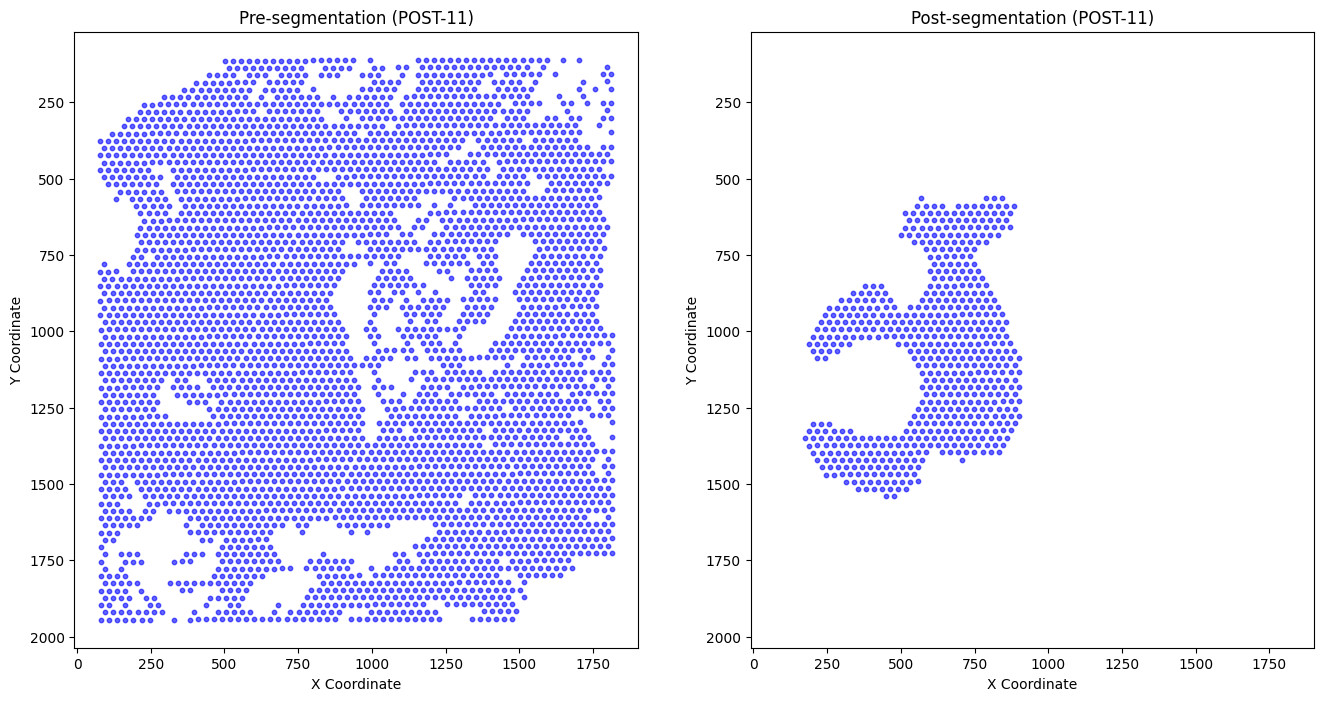

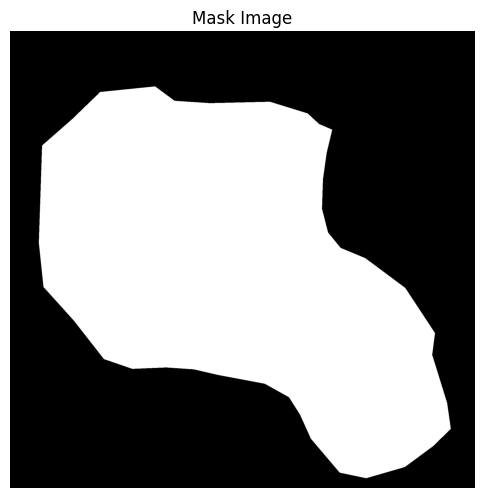

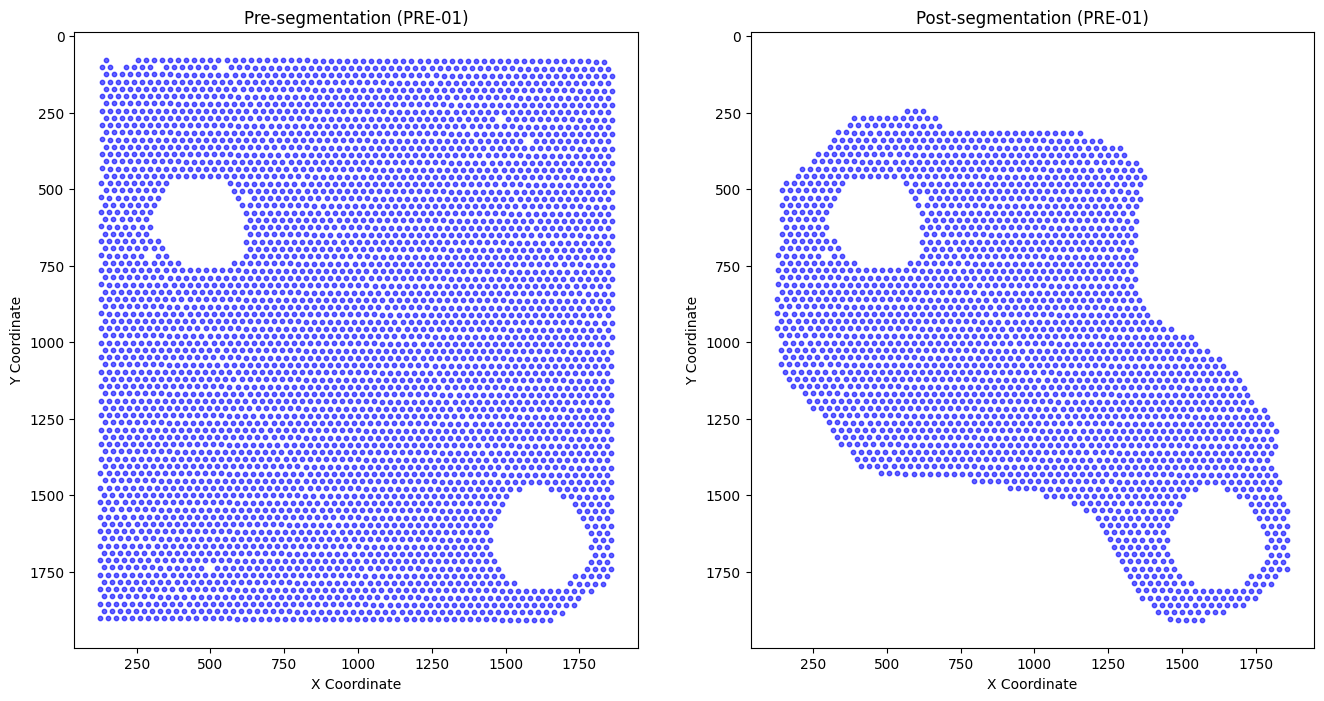

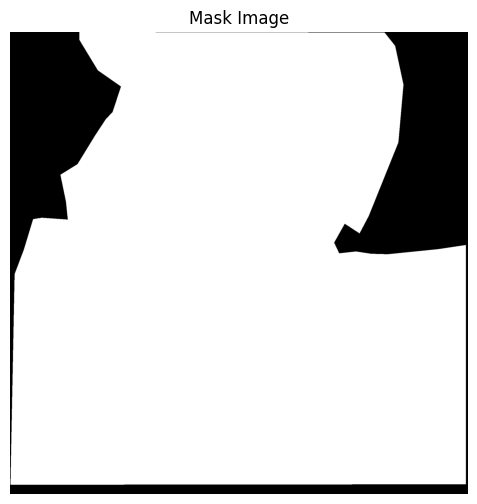

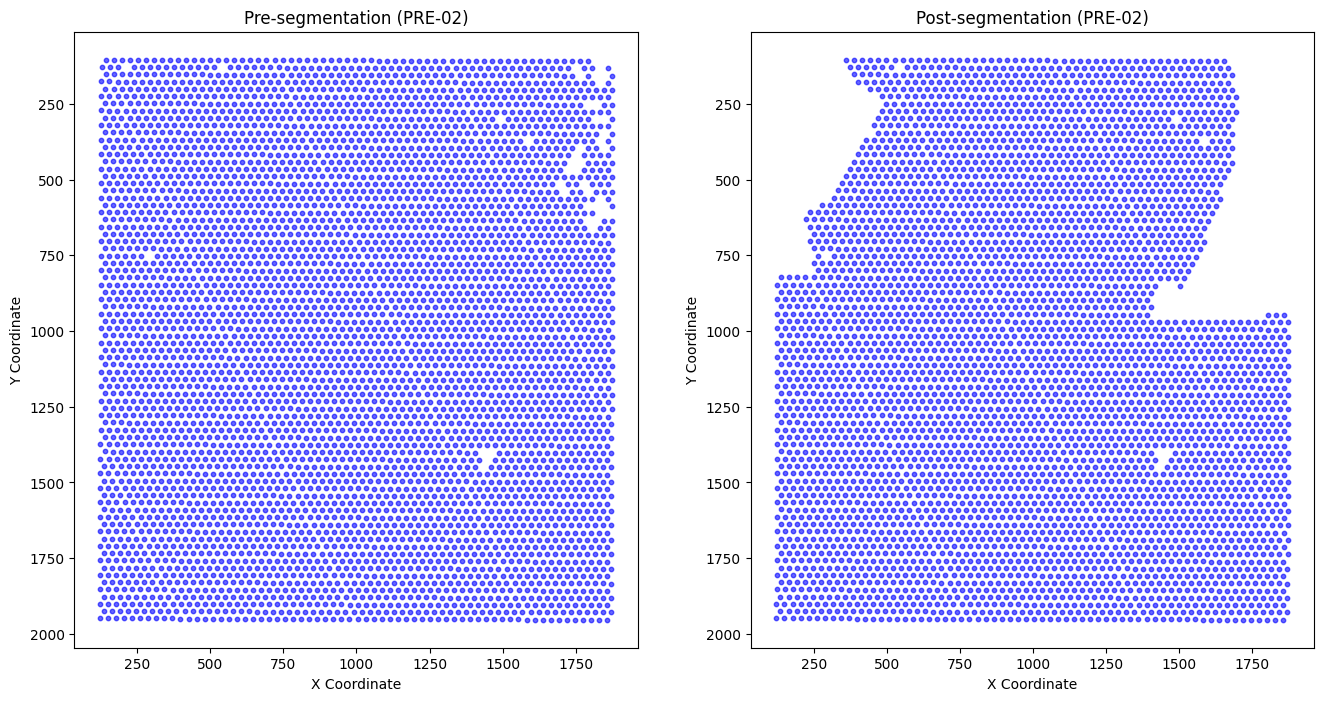

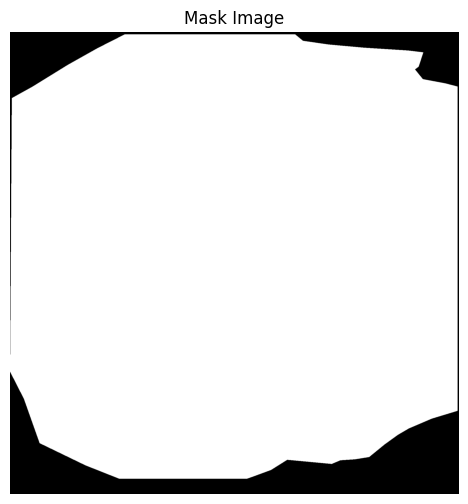

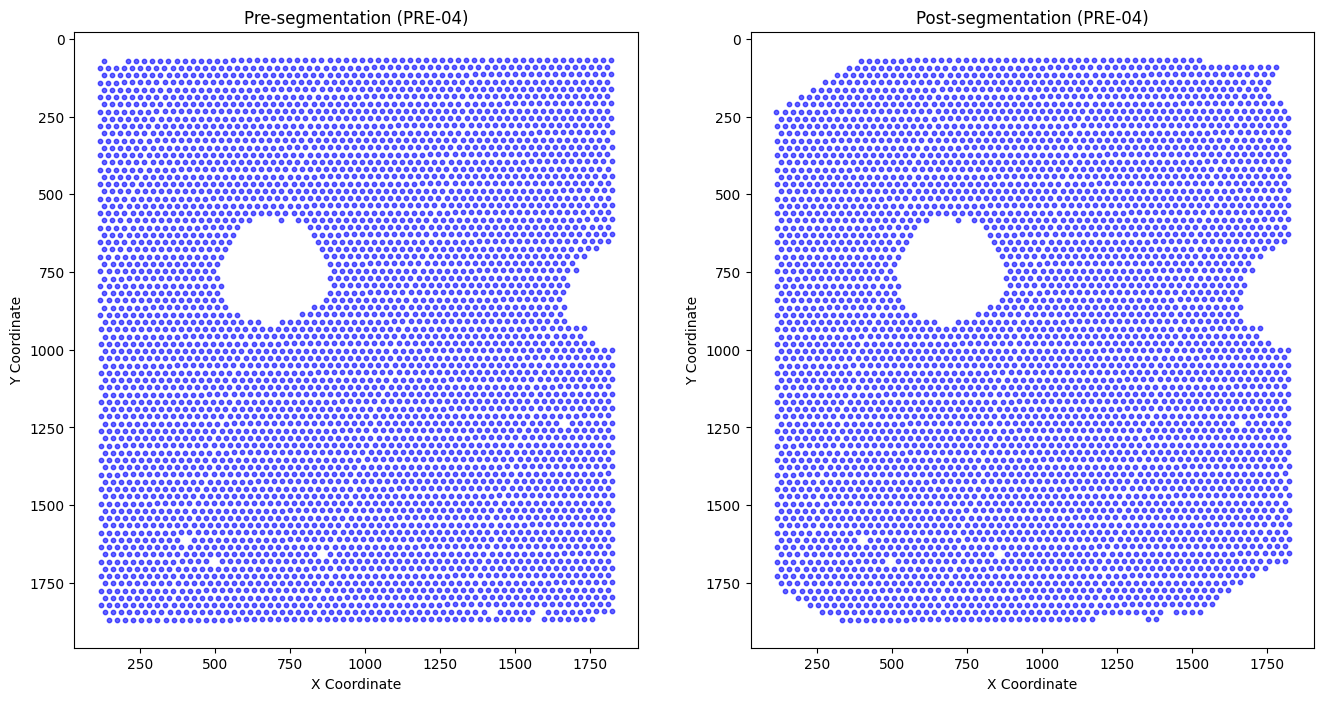

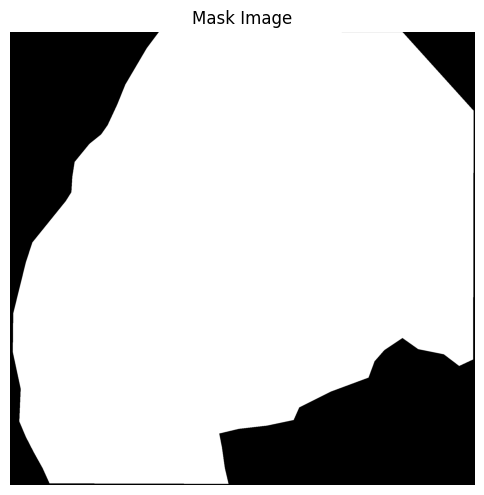

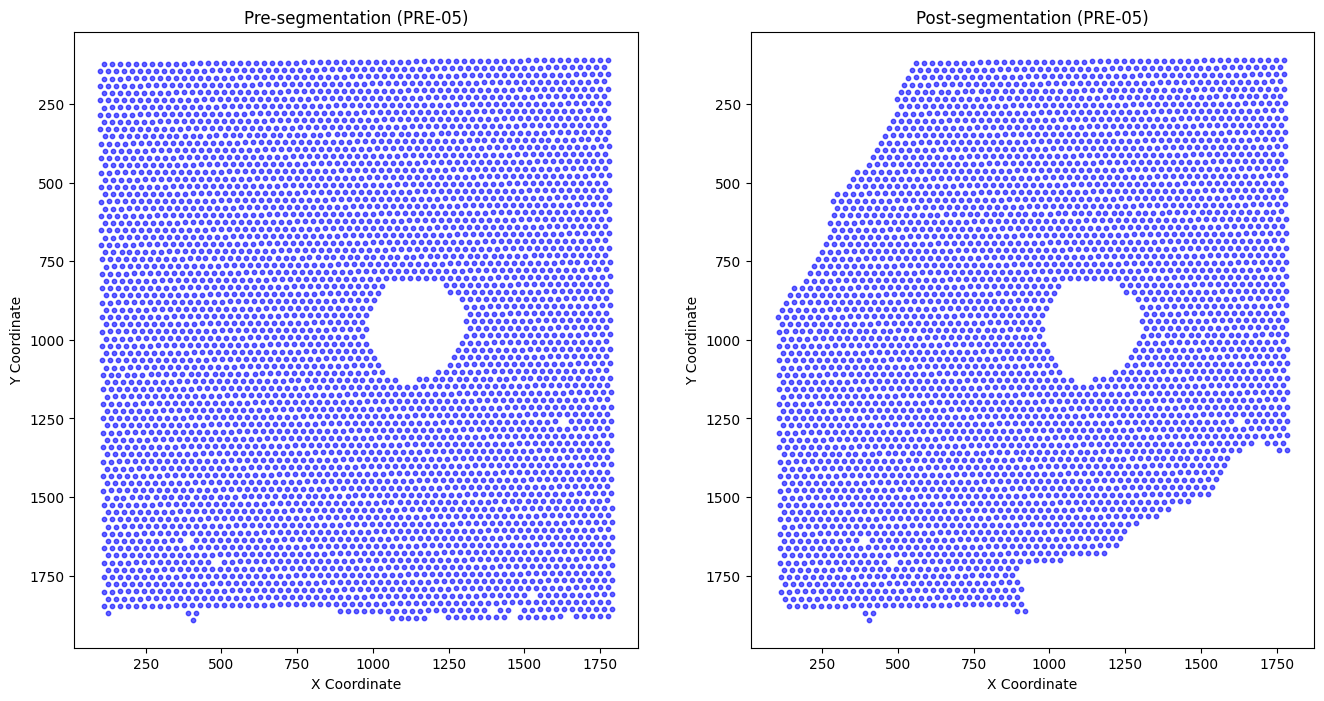

In [2]:
import SimpleITK as sitk
import matplotlib.pyplot as plt
import numpy as np
import pickle
import squidpy as sq #package for handling spatial transcriptomics data sets
import scanpy as sc

# Load data
with open('/tmp/work/Visium/BRCA_2024/objects/visium_samples_inclusive.pkl', 'rb') as file:
    visium_samples = pickle.load(file)

# upper_path = '/tmp/work/Visium/BRCA_2024/image_masks/POST-06_upper_Mask.png'
post06_mask = '/tmp/work/Visium/BRCA_2024/image_masks/POST-06_lower_Mask.png'
post03_mask = '/tmp/work/Visium/BRCA_2024/image_masks/POST-03_Mask.png'
post05_mask = '/tmp/work/Visium/BRCA_2024/image_masks/POST-05_Mask.png'
post11_mask = '/tmp/work/Visium/BRCA_2024/image_masks/POST-11_Mask.png'

pre01_mask = '/tmp/work/Visium/BRCA_2024/image_masks/PRE-01_Mask.png'
pre02_mask = '/tmp/work/Visium/BRCA_2024/image_masks/PRE-02_Mask.png'
pre04_mask = '/tmp/work/Visium/BRCA_2024/image_masks/PRE-04_Mask.png'
pre05_mask = '/tmp/work/Visium/BRCA_2024/image_masks/PRE-05_Mask.png'

sample_name = 'POST-06'

def applyMask(mask_path, visium_object, sample_name):  
    adata = visium_object[sample_name]
    # Read and convert image
    image = sitk.ReadImage(mask_path)
    image_array = sitk.GetArrayFromImage(image)
    binarized_image = np.where(image_array > 0, 1, 0)  # Binarize the image

    # # Display the mask image
    fig, axs = plt.subplots(1, 1, figsize=(6, 6))
    axs.imshow(image_array, cmap='gray')
    axs.set_title('Mask Image')
    axs.axis('off')
    plt.show()

    # Get spatial coordinates and apply scaling
    coordinates = adata.obsm['spatial'] * adata.uns['spatial'][sample_name]['scalefactors']['tissue_hires_scalef']

    overlap_vector = []
    for coord in coordinates:
        x, y = coord

        if np.isnan(x) or np.isnan(y):
            overlap_vector.append(False)
            continue

        # Round coordinates
        x_rounded, y_rounded = int(round(x)), int(round(y))

        # Check bounds and pixel value
        if (0 <= x_rounded < binarized_image.shape[1]) and (0 <= y_rounded < binarized_image.shape[0]):
            overlap_vector.append(binarized_image[y_rounded, x_rounded] == 1)
        else:
            overlap_vector.append(False)

    # Filter data
    overlap_vector = np.array(overlap_vector)
    filtered_coordinates = coordinates[overlap_vector]
    filtered_adata = adata[overlap_vector, :]

    # Visualization of filtering
    spatial_coords = adata.obsm['spatial'] * adata.uns['spatial'][sample_name]['scalefactors']['tissue_hires_scalef']
    
    fig, axs = plt.subplots(1, 2, figsize=(16, 8))
    
    # Plot pre-segmentation
    axs[0].scatter(spatial_coords[:, 0], spatial_coords[:, 1], s=10, c='blue', alpha=0.6)
    axs[0].invert_yaxis()
    axs[0].set_title(f'Pre-segmentation ({sample_name})')
    axs[0].set_xlabel('X Coordinate')
    axs[0].set_ylabel('Y Coordinate')
    
    # Capture axis limits from the first plot
    x_limits = axs[0].get_xlim()
    y_limits = axs[0].get_ylim()
    
    # Plot post-segmentation with inherited axis limits
    spatial_coords_filtered = filtered_adata.obsm['spatial'] * adata.uns['spatial'][sample_name]['scalefactors']['tissue_hires_scalef']
    axs[1].scatter(spatial_coords_filtered[:, 0], spatial_coords_filtered[:, 1], s=10, c='blue', alpha=0.6)
    axs[1].invert_yaxis()
    axs[1].set_title(f'Post-segmentation ({sample_name})')
    axs[1].set_xlabel('X Coordinate')
    axs[1].set_ylabel('Y Coordinate')
    
    # Apply the captured axis limits to the second plot
    axs[1].set_xlim(x_limits)
    axs[1].set_ylim(y_limits)
    
    plt.show()

    return filtered_adata

# Call the function
# top_data = applyMask(upper_path, adata, sample_name)

post06 = applyMask(post06_mask, visium_samples, 'POST-06')
post03 = applyMask(post03_mask, visium_samples, 'POST-03')
post05 = applyMask(post05_mask, visium_samples,'POST-05')
post11 = applyMask(post11_mask, visium_samples,'POST-11')

pre01 = applyMask(pre01_mask, visium_samples, 'PRE-01')
pre02 = applyMask(pre02_mask, visium_samples, 'PRE-02')
pre04 = applyMask(pre04_mask, visium_samples, 'PRE-04')
pre05 = applyMask(pre05_mask, visium_samples, 'PRE-05')

In [3]:
import pandas as pd

meta_csv_path = '/tmp/work/Visium/BRCA_2024/brca_nbs_previous/seurat_meta.csv'
meta_df = pd.read_csv(meta_csv_path)
meta_df = meta_df.rename(columns={'Unnamed: 0': 'spot_name'})
meta_df['spot_name'] = meta_df['spot_name'].str.slice(0, -2)

def get_dn_cos(sample_name,sample_variable_name):
    current_meta =  meta_df[meta_df["sample"]==sample_name][["spot_name","dn_b_cos"]]
    row_names = sample_variable_name.obs.index.tolist()
    subset_df = current_meta[current_meta["spot_name"].isin(row_names)]
    output_vector = subset_df['dn_b_cos']
    return output_vector

In [4]:
predictions_meta_path = '/tmp/work/Visium/BRCA_2024/brca_nbs_previous/predictions_meta.csv'

predictions_df = pd.read_csv(predictions_meta_path)
predictions_df = predictions_df.rename(columns={'Unnamed: 0': 'spot_name'})
predictions_df['spot_name'] = predictions_df['spot_name'].str.slice(0, -2)

def get_AtM_pred(sample_name,sample_variable_name):
    current_meta =  predictions_df[predictions_df["sample_names"]==sample_name][["spot_name","B.09.DUSP4+AtM"]]
    row_names = sample_variable_name.obs.index.tolist()
    subset_df = current_meta[current_meta["spot_name"].isin(row_names)]
    output_vector = subset_df['B.09.DUSP4+AtM']
    return output_vector

In [5]:
## execute for to compare wihtout mask application

no_mask = False

if no_mask:
    post06 = visium_samples['POST-06']
    post03 = visium_samples['POST-03']
    post05 = visium_samples['POST-05']
    post11 = visium_samples['POST-11']
    
    pre01 =  visium_samples['PRE-01']
    pre02 =  visium_samples['PRE-02']
    pre04 =  visium_samples['PRE-04']
    pre05 =  visium_samples['PRE-05']

    print("no mask applied")

T-statistic: -0.8057, p-value: 0.4773


/tmp/ipykernel_283511/2305909267.py:38: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.pointplot(x='Sample', y='Value', data=data, markers='o', capsize=0.1, join=False, color='red', ci=None)
/tmp/ipykernel_283511/2305909267.py:38: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(x='Sample', y='Value', data=data, markers='o', capsize=0.1, join=False, color='red', ci=None)


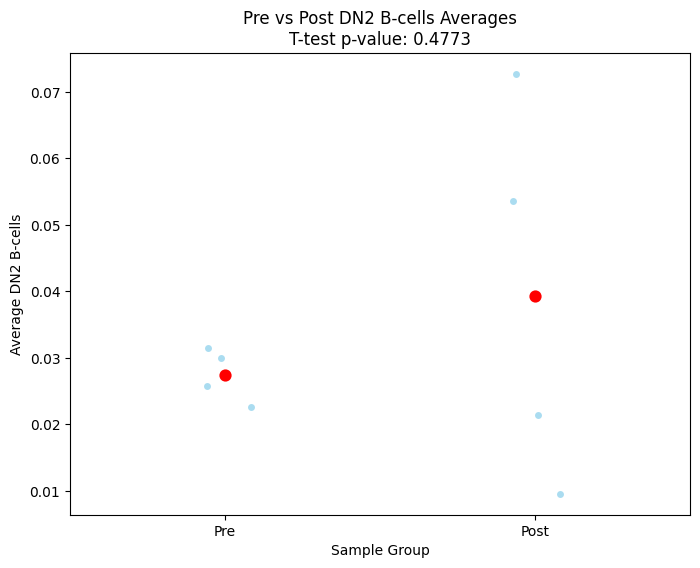

In [6]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

current_obs = 'DN2_Bcells'
# current_obs = 'n_genes'
# current_obs = 'Goff_Agpresentation'
# current_obs = 'B-cells_cos_sim'

# Data for "post" samples
post_samples = [
    np.mean(post06.obs[current_obs]),
    np.mean(post03.obs[current_obs]),
    np.mean(post05.obs[current_obs]),
    np.mean(post11.obs[current_obs])
]

# Data for "pre" samples
pre_samples = [
    np.mean(pre01.obs[current_obs]),
    np.mean(pre02.obs[current_obs]),
    np.mean(pre04.obs[current_obs]),
    np.mean(pre05.obs[current_obs])
]

# Perform a t-test
t_stat, p_value = stats.ttest_ind(pre_samples, post_samples, equal_var=False)
print(f"T-statistic: {t_stat:.4f}, p-value: {p_value:.4f}")

# Prepare data for plotting
data = {'Sample': ['Pre'] * len(pre_samples) + ['Post'] * len(post_samples),
        'Value': pre_samples + post_samples}

# Create a scatter plot with averages
plt.figure(figsize=(8, 6))
sns.stripplot(x='Sample', y='Value', data=data, jitter=True, alpha=0.7, color='skyblue')
sns.pointplot(x='Sample', y='Value', data=data, markers='o', capsize=0.1, join=False, color='red', ci=None)

# Add title and labels
plt.title(f'Pre vs Post DN2 B-cells Averages\nT-test p-value: {p_value:.4f}')
plt.xlabel('Sample Group')
plt.ylabel('Average DN2 B-cells')
plt.show()


T-statistic: -5.3033, p-value: 0.0000


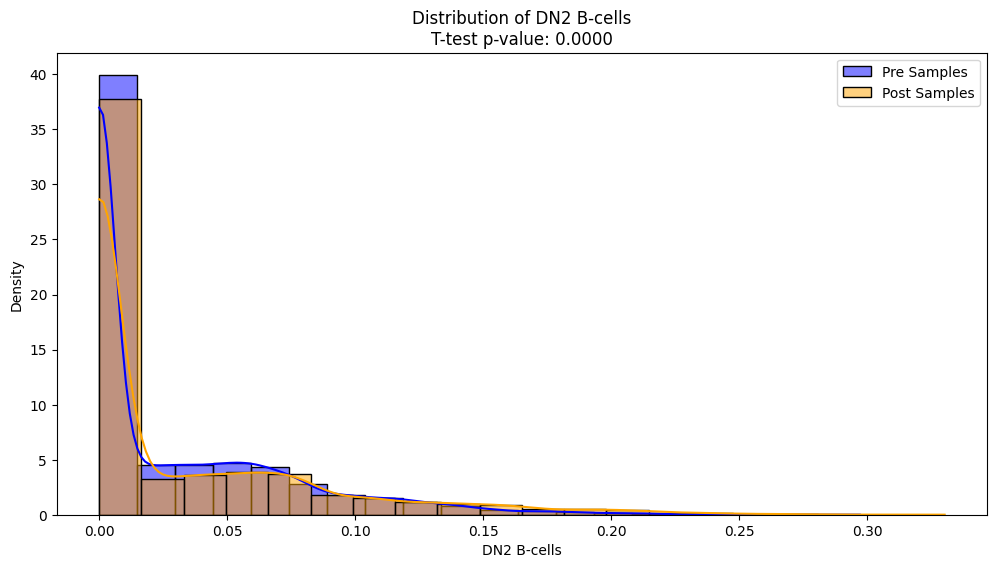

In [7]:
# Example data (replace these with your actual observations)
post06_dn2 = post06.obs[current_obs]
post03_dn2 = post03.obs[current_obs]
post05_dn2 = post05.obs[current_obs]
post11_dn2 = post11.obs[current_obs]

pre01_dn2 = pre01.obs[current_obs]
pre02_dn2 = pre02.obs[current_obs]
pre04_dn2 = pre04.obs[current_obs]
pre05_dn2 = pre05.obs[current_obs]

# Combine the data into arrays for pre and post samples
post_samples = [post06_dn2, post03_dn2, post05_dn2, post11_dn2]
pre_samples = [pre01_dn2, pre02_dn2, pre04_dn2, pre05_dn2]

# Flatten the data for distributions
post_distribution = np.concatenate(post_samples)
pre_distribution = np.concatenate(pre_samples)

# Perform a t-test
t_stat, p_value = stats.ttest_ind(pre_distribution, post_distribution, equal_var=False)
print(f"T-statistic: {t_stat:.4f}, p-value: {p_value:.4f}")

# Set up the figure
plt.figure(figsize=(12, 6))

# Plot the distributions
sns.histplot(pre_distribution, bins=20, kde=True, color='blue', label='Pre Samples', stat='density', alpha=0.5)
sns.histplot(post_distribution, bins=20, kde=True, color='orange', label='Post Samples', stat='density', alpha=0.5)

# Add titles and labels
plt.title(f'Distribution of DN2 B-cells\nT-test p-value: {p_value:.4f}')
plt.xlabel('DN2 B-cells')
plt.ylabel('Density')
plt.legend()
plt.show()

T-statistic: -0.7145, p-value: 0.5019


/tmp/ipykernel_283511/3277185519.py:28: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.pointplot(x='Sample', y='Value', data=data, markers='o', capsize=0.1, join=False, color='red', ci=None)
/tmp/ipykernel_283511/3277185519.py:28: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(x='Sample', y='Value', data=data, markers='o', capsize=0.1, join=False, color='red', ci=None)


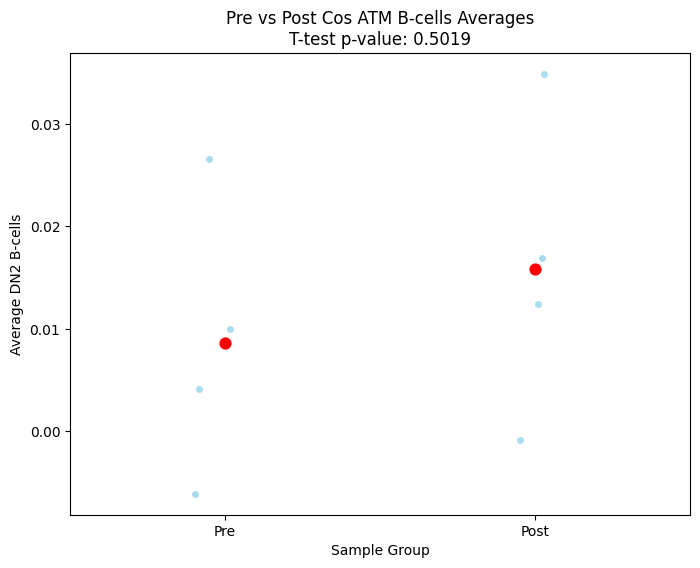

In [8]:

# Data for "post" samples
post_samples = [
    np.mean(get_dn_cos('POST-06',post06)),
    np.mean(get_dn_cos('POST-03',post03)),
    np.mean(get_dn_cos('POST-05',post05)),
    np.mean(get_dn_cos('POST-11',post11))
]

# Data for "pre" samples
pre_samples = [
    np.mean(get_dn_cos('PRE-01',pre01)),
    np.mean(get_dn_cos('PRE-02',pre02)),
    np.mean(get_dn_cos('PRE-04',pre04)),
    np.mean(get_dn_cos('PRE-05',pre05))
]

# Perform a t-test
t_stat, p_value = stats.ttest_ind(pre_samples, post_samples, equal_var=False)
print(f"T-statistic: {t_stat:.4f}, p-value: {p_value:.4f}")

# Prepare data for plotting
data = {'Sample': ['Pre'] * len(pre_samples) + ['Post'] * len(post_samples),
        'Value': pre_samples + post_samples}

# Create a scatter plot with averages
plt.figure(figsize=(8, 6))
sns.stripplot(x='Sample', y='Value', data=data, jitter=True, alpha=0.7, color='skyblue')
sns.pointplot(x='Sample', y='Value', data=data, markers='o', capsize=0.1, join=False, color='red', ci=None)

# Add title and labels
plt.title(f'Pre vs Post Cos ATM B-cells Averages\nT-test p-value: {p_value:.4f}')
plt.xlabel('Sample Group')
plt.ylabel('Average DN2 B-cells')
plt.show()

T-statistic: -5.0244, p-value: 0.0000


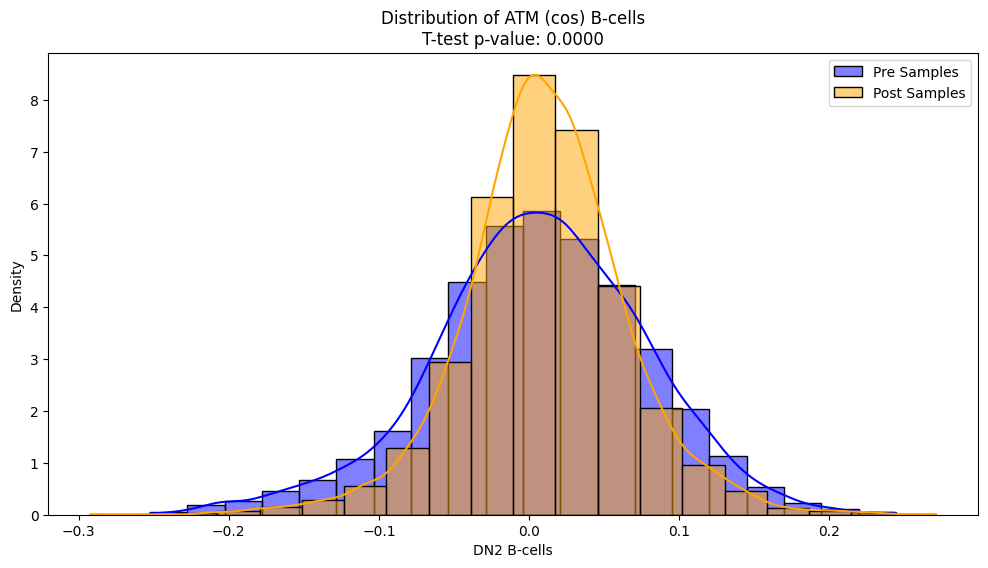

In [9]:
# Example data (replace these with your actual observations)
post06_dn2 = get_dn_cos('POST-06',post06)
post03_dn2 = get_dn_cos('POST-03',post03)
post05_dn2 = get_dn_cos('POST-05',post05)
post11_dn2 = get_dn_cos('POST-11',post11)

pre01_dn2 = get_dn_cos('PRE-01',pre01)
pre02_dn2 = get_dn_cos('PRE-02',pre02)
pre04_dn2 = get_dn_cos('PRE-04',pre04)
pre05_dn2 = get_dn_cos('PRE-05',pre05)

# Combine the data into arrays for pre and post samples
post_samples = [post06_dn2, post03_dn2, post05_dn2, post11_dn2]
pre_samples = [pre01_dn2, pre02_dn2, pre04_dn2, pre05_dn2]

# Flatten the data for distributions
post_distribution = np.concatenate(post_samples)
pre_distribution = np.concatenate(pre_samples)

# Perform a t-test
t_stat, p_value = stats.ttest_ind(pre_distribution, post_distribution, equal_var=False)
print(f"T-statistic: {t_stat:.4f}, p-value: {p_value:.4f}")

# Set up the figure
plt.figure(figsize=(12, 6))

# Plot the distributions
sns.histplot(pre_distribution, bins=20, kde=True, color='blue', label='Pre Samples', stat='density', alpha=0.5)
sns.histplot(post_distribution, bins=20, kde=True, color='orange', label='Post Samples', stat='density', alpha=0.5)

# Add titles and labels
plt.title(f'Distribution of ATM (cos) B-cells\nT-test p-value: {p_value:.4f}')
plt.xlabel('DN2 B-cells')
plt.ylabel('Density')
plt.legend()
plt.show()

T-statistic: -0.8283, p-value: 0.4643


/tmp/ipykernel_283511/62480785.py:28: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.pointplot(x='Sample', y='Value', data=data, markers='o', capsize=0.1, join=False, color='red', ci=None)
/tmp/ipykernel_283511/62480785.py:28: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(x='Sample', y='Value', data=data, markers='o', capsize=0.1, join=False, color='red', ci=None)


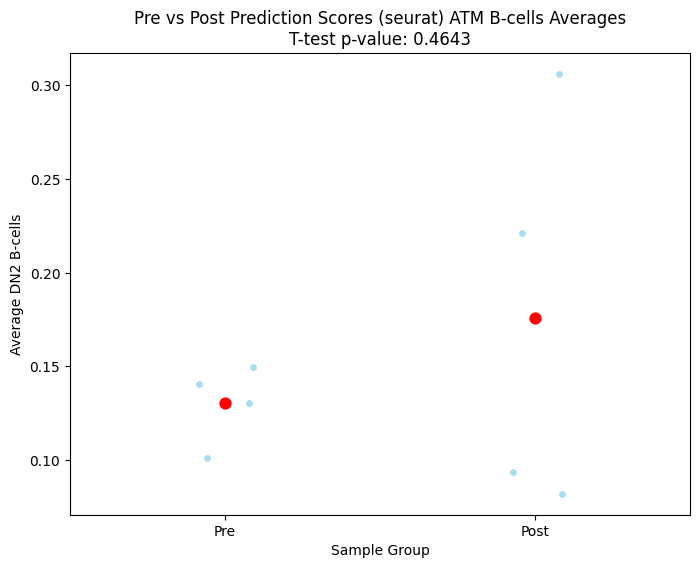

In [10]:

# Data for "post" samples
post_samples = [
    np.mean(get_AtM_pred('POST-06',post06)),
    np.mean(get_AtM_pred('POST-03',post03)),
    np.mean(get_AtM_pred('POST-05',post05)),
    np.mean(get_AtM_pred('POST-11',post11))
]

# Data for "pre" samples
pre_samples = [
    np.mean(get_AtM_pred('PRE-01',pre01)),
    np.mean(get_AtM_pred('PRE-02',pre02)),
    np.mean(get_AtM_pred('PRE-04',pre04)),
    np.mean(get_AtM_pred('PRE-05',pre05))
]

# Perform a t-test
t_stat, p_value = stats.ttest_ind(pre_samples, post_samples, equal_var=False)
print(f"T-statistic: {t_stat:.4f}, p-value: {p_value:.4f}")

# Prepare data for plotting
data = {'Sample': ['Pre'] * len(pre_samples) + ['Post'] * len(post_samples),
        'Value': pre_samples + post_samples}

# Create a scatter plot with averages
plt.figure(figsize=(8, 6))
sns.stripplot(x='Sample', y='Value', data=data, jitter=True, alpha=0.7, color='skyblue')
sns.pointplot(x='Sample', y='Value', data=data, markers='o', capsize=0.1, join=False, color='red', ci=None)

# Add title and labels
plt.title(f'Pre vs Post Prediction Scores (seurat) ATM B-cells Averages\nT-test p-value: {p_value:.4f}')
plt.xlabel('Sample Group')
plt.ylabel('Average DN2 B-cells')
plt.show()

T-statistic: -1.5630, p-value: 0.1181


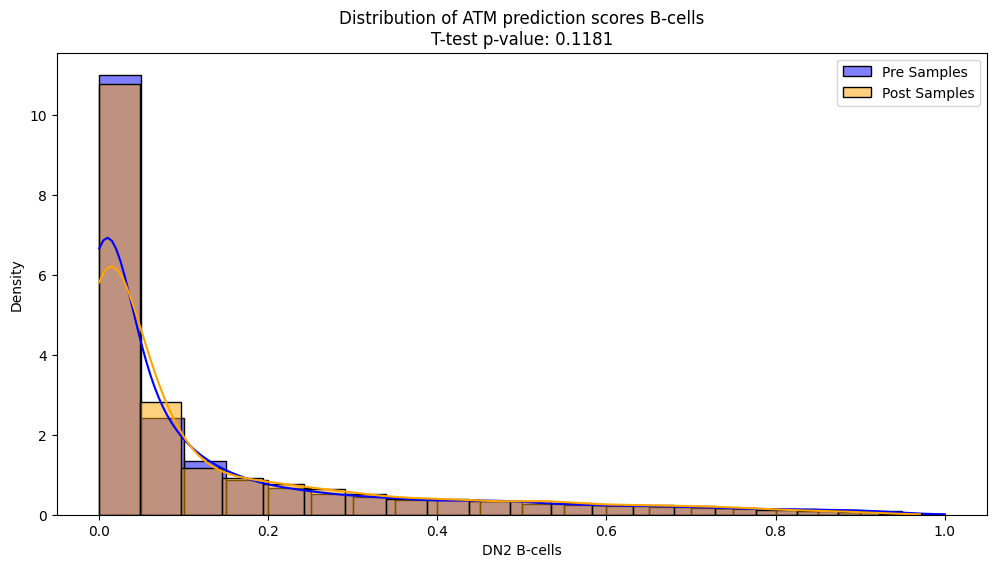

In [11]:
# Example data (replace these with your actual observations)
post06_dn2 = get_AtM_pred('POST-06',post06)
post03_dn2 = get_AtM_pred('POST-03',post03)
post05_dn2 = get_AtM_pred('POST-05',post05)
post11_dn2 = get_AtM_pred('POST-11',post11)

pre01_dn2 = get_AtM_pred('PRE-01',pre01)
pre02_dn2 = get_AtM_pred('PRE-02',pre02)
pre04_dn2 = get_AtM_pred('PRE-04',pre04)
pre05_dn2 = get_AtM_pred('PRE-05',pre05)

# Combine the data into arrays for pre and post samples
post_samples = [post06_dn2, post03_dn2, post05_dn2, post11_dn2]
pre_samples = [pre01_dn2, pre02_dn2, pre04_dn2, pre05_dn2]

# Flatten the data for distributions
post_distribution = np.concatenate(post_samples)
pre_distribution = np.concatenate(pre_samples)

# Perform a t-test
t_stat, p_value = stats.ttest_ind(pre_distribution, post_distribution, equal_var=False)
print(f"T-statistic: {t_stat:.4f}, p-value: {p_value:.4f}")

# Set up the figure
plt.figure(figsize=(12, 6))

# Plot the distributions
sns.histplot(pre_distribution, bins=20, kde=True, color='blue', label='Pre Samples', stat='density', alpha=0.5)
sns.histplot(post_distribution, bins=20, kde=True, color='orange', label='Post Samples', stat='density', alpha=0.5)

# Add titles and labels
plt.title(f'Distribution of ATM prediction scores B-cells\nT-test p-value: {p_value:.4f}')
plt.xlabel('DN2 B-cells')
plt.ylabel('Density')
plt.legend()
plt.show()